In [15]:
from art.utils import load_dataset
from art.classifiers import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from art.metrics import empirical_robustness

import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# Loading hand writing dataset

In [16]:
def exract_two_classes( data, labels, classes=(0,1), no_instance=10000):
    data_zeroes = data[ np.argwhere( labels ==  classes[0] ).reshape( -1 ) ][ :no_instance ]
    data_ones = data[ np.argwhere( labels == classes[1] ).reshape( -1 ) ][ :no_instance ]
    x = np.vstack( (data_zeroes, data_ones) )
    
    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

In [17]:
mnist = tf.keras.datasets.fashion_mnist # Object of the MNIST dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data() # Load data

# extract ones and zeroes
x_train, y_train = exract_two_classes( x_train, y_train )
x_test, y_test = exract_two_classes( x_test, y_test )

In [18]:
x_train = np.array(x_train).astype("float")
y_train = np.array(y_train).astype("float")
x_test = np.array(x_test).astype("float")
y_test = np.array(y_test).astype("float")

In [19]:
print("Lengh of dimensions for x_train: ", x_train.shape)
print("Lengh of dimensions for y_train: ", y_train.shape)
print("Lengh of dimensions for x_test: ", x_test.shape)
print("Lengh of dimensions for y_test: ", y_test.shape)

Lengh of dimensions for x_train:  (12000, 28, 28)
Lengh of dimensions for y_train:  (12000,)
Lengh of dimensions for x_test:  (2000, 28, 28)
Lengh of dimensions for y_test:  (2000,)


In [20]:
'''reshape'''
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

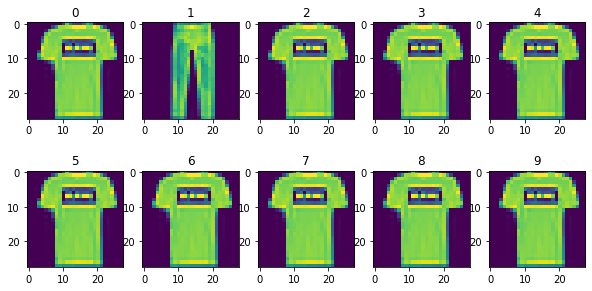

In [21]:
n_classes = 10
inds=np.array([y_train==i for i in range(n_classes)])
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(x_train[np.argmax(inds[i])].reshape(28,28))
    ax[i].set_title(str(i))
plt.show()

# Simple fully-connected neural network with 2 hidden layers

In [22]:
np.random.seed(44)
model = tf.keras.Sequential([
    # 1st convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # 2nd convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') 
])

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss=loss_object,
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 20)        200       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 11, 11, 20)        3620      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 20)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [23]:
'''Traning the model'''
history = model.fit(x_train, y_train, epochs=5, verbose=1,
                    validation_data=(x_test, y_test))

#(train_x, train_y, epochs=5,validation_data=(valid_x, valid_y))

Epoch 1/5
375/375 [==============================] - 6s 14ms/step - loss: 0.2172 - accuracy: 0.9476 - val_loss: 0.0310 - val_accuracy: 0.9870
Epoch 2/5
375/375 [==============================] - 5s 13ms/step - loss: 0.0335 - accuracy: 0.9871 - val_loss: 0.0241 - val_accuracy: 0.9890
Epoch 3/5
375/375 [==============================] - 4s 10ms/step - loss: 0.0219 - accuracy: 0.9927 - val_loss: 0.0186 - val_accuracy: 0.9910
Epoch 4/5
375/375 [==============================] - 5s 13ms/step - loss: 0.0190 - accuracy: 0.9940 - val_loss: 0.0229 - val_accuracy: 0.9925
Epoch 5/5
375/375 [==============================] - 5s 13ms/step - loss: 0.0165 - accuracy: 0.9938 - val_loss: 0.0183 - val_accuracy: 0.9925


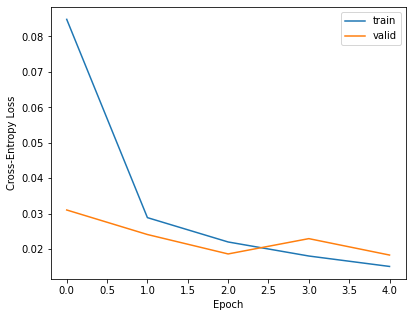

In [24]:
'''Plot loss trajectory throughout training'''
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

Test cross-entropy loss: 0.01831
Test accuracy: 0.99250


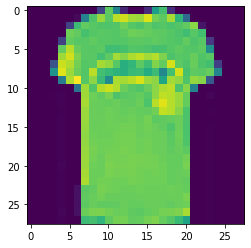

In [25]:
'''Score on original data'''
score = model.evaluate(x_test, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(x_test[0])  
plt.show()

# FGSM attack 

In [26]:
'''wrap the model an calculte emperical robustnees'''
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(28,28,1),
                                   loss_object = loss_object, clip_values=(0, 1))
print('robustness of the undefended model', 
      empirical_robustness(classifier, x_test, 'fgsm', {}))

robustness of the undefended model 0.16838571199008295


In [27]:
eps_list=np.arange(0.01, 0.1, 0.01)
acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    '''
    creat adversial examples using build in FastGradientMethod from ART
    also predict based on the current  adversial examples
    '''

    adv_fgsm_model = FastGradientMethod(classifier, norm=1, eps=eps_list[i]*784, targeted=False)
    adv_fgsm_x = adv_fgsm_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_fgsm_x)
    acc[i]=classifier._model.evaluate(adv_fgsm_x, y_test)[1]
    print(eps_list[i])

63/63 [==============================] - 0s 4ms/step - loss: 0.0604 - accuracy: 0.9715
0.01
63/63 [==============================] - 0s 6ms/step - loss: 0.2075 - accuracy: 0.9255
0.02
63/63 [==============================] - 0s 3ms/step - loss: 0.4464 - accuracy: 0.8555
0.03
63/63 [==============================] - 0s 5ms/step - loss: 0.7419 - accuracy: 0.7960
0.04
63/63 [==============================] - 0s 4ms/step - loss: 1.0534 - accuracy: 0.7180
0.05
63/63 [==============================] - 0s 4ms/step - loss: 1.3556 - accuracy: 0.6570
0.060000000000000005
63/63 [==============================] - 0s 6ms/step - loss: 1.6381 - accuracy: 0.6100
0.06999999999999999
63/63 [==============================] - 0s 4ms/step - loss: 1.8951 - accuracy: 0.5705
0.08
63/63 [==============================] - 0s 5ms/step - loss: 2.1268 - accuracy: 0.5405
0.09


In [124]:
eps_list=np.arange(0.01, 0.1, 0.01)
acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    '''
    creat adversial examples using build in FastGradientMethod from ART
    also predict based on the current  adversial examples
    '''

    adv_fgsm_model = FastGradientMethod(classifier, norm=2, eps=eps_list[i]*784, targeted=False)
    adv_fgsm_x = adv_fgsm_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_fgsm_x)
    acc[i]=classifier._model.evaluate(adv_fgsm_x, y_test)[1]
    print(eps_list[i])

63/63 [==============================] - 0s 4ms/step - loss: 5.0817 - accuracy: 0.3735
0.01
63/63 [==============================] - 0s 3ms/step - loss: 6.5831 - accuracy: 0.4075
0.02
63/63 [==============================] - 0s 3ms/step - loss: 7.1687 - accuracy: 0.4220
0.03
63/63 [==============================] - 0s 3ms/step - loss: 7.4882 - accuracy: 0.4340
0.04
63/63 [==============================] - 0s 3ms/step - loss: 7.7095 - accuracy: 0.4415
0.05
63/63 [==============================] - 0s 3ms/step - loss: 7.8698 - accuracy: 0.4400
0.060000000000000005
63/63 [==============================] - 0s 3ms/step - loss: 7.9907 - accuracy: 0.4420
0.06999999999999999
63/63 [==============================] - 0s 3ms/step - loss: 8.0807 - accuracy: 0.4435
0.08
63/63 [==============================] - 0s 3ms/step - loss: 8.1478 - accuracy: 0.4450
0.09


In [125]:
eps_list=np.arange(0.01, 0.1, 0.01)
acc=np.zeros(eps_list.size)
for i in range(eps_list.size):
    '''
    creat adversial examples using build in FastGradientMethod from ART
    also predict based on the current  adversial examples
    '''

    adv_fgsm_model = FastGradientMethod(classifier, norm=np.inf, eps=eps_list[i], targeted=False)
    adv_fgsm_x = adv_fgsm_model.generate(x=x_test)
    prediction_x = classifier.predict(x=adv_fgsm_x)
    acc[i]=classifier._model.evaluate(adv_fgsm_x, y_test)[1]
    print(eps_list[i])

63/63 [==============================] - 0s 4ms/step - loss: 0.0287 - accuracy: 0.9855
0.01
63/63 [==============================] - 0s 3ms/step - loss: 0.0447 - accuracy: 0.9830
0.02
63/63 [==============================] - 0s 3ms/step - loss: 0.0766 - accuracy: 0.9710
0.03
63/63 [==============================] - 0s 3ms/step - loss: 0.1281 - accuracy: 0.9565
0.04
63/63 [==============================] - 0s 3ms/step - loss: 0.2028 - accuracy: 0.9215
0.05
63/63 [==============================] - 0s 3ms/step - loss: 0.3031 - accuracy: 0.8800
0.060000000000000005
63/63 [==============================] - 0s 4ms/step - loss: 0.4295 - accuracy: 0.8370
0.06999999999999999
63/63 [==============================] - 0s 4ms/step - loss: 0.5786 - accuracy: 0.7835
0.08
63/63 [==============================] - 0s 4ms/step - loss: 0.7490 - accuracy: 0.7255
0.09


# -------------------------------------------

In [126]:
# print('class prediction for the adversarial sample:',classifier.predict(adv_fgsm_x))
print('accuracy on adversarial examples:' )
print(classifier._model.evaluate(adv_fgsm_x, y_test)[1])

accuracy on adversarial examples:
63/63 [==============================] - 0s 4ms/step - loss: 0.7490 - accuracy: 0.7255
0.7254999876022339


Test cross-entropy loss: 0.74897
Test accuracy: 0.72550


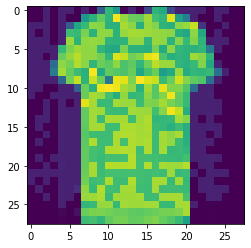

In [127]:
'''Score on adversarial examples'''
score = model.evaluate(adv_fgsm_x, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.5f' % score[1])
plt.figure()
plt.imshow(adv_fgsm_x[0])  
plt.show()